In [1]:
import pandas as pd
import numpy as np
import math

import warnings
warnings.filterwarnings("ignore")

# from sparktorch import serialize_torch_obj, SparkTorch, PysparkPipelineWrapper
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import udf, lit
from pyspark.sql.types import *
# from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import constant
import tools

# 1.Methods
## load

In [6]:
def _load_parquet(path, schema:StructType = None):
    """
    load apache parquet file
    """
    return sqlContext.read.schema(schema).parquet(path) if schema is not None else sqlContext.read.parquet(path)

def _load_weather_Pandas(path):
    """
    load apache parquet file
    """
    return pd.read_parquet(path)

def _load_csv(path, schema:StructType = None):
    """
    load csv file
    """
    if schema == None:
        return sqlContext.read.csv(path, sep=",", header=True, inferSchema="true")
    return sqlContext.read.csv(path, sep=",", header=True, schema=schema)


def load_files():
# to read parquet file
    settlement = _load_parquet(constant.settlement_2019_path, constant.settlement_schema_2)
    settlement = settlement.dropna(subset =["VAERDI"])
                # .withColumn("VAERDI", settlement["VAERDI"].cast("double"))
    
    windmill = _load_csv(constant.windmill_test_path, constant.windmills_schema)
    windmill = _load_csv(constant.windmill_geo_analysis_path, constant.windmills_schema_2)
   
    wu10_dic = _load_weather_Pandas(constant.wu10_path).reset_index()
    wv10_dic = _load_weather_Pandas(constant.wv10_path).reset_index()
    wu100_dic = _load_weather_Pandas(constant.wu100_path).reset_index()
    wv100_dic = _load_weather_Pandas(constant.wv100_path).reset_index()
    tmp2_dic = _load_weather_Pandas(constant.tmp2_c_path).reset_index()
    tmp100_dic = _load_weather_Pandas(constant.tmp100_c_path).reset_index()
    tools.get_udf(wu10_dic, wv10_dic, wu100_dic, wv100_dic, tmp2_dic, tmp100_dic)

    return settlement, windmill

In [3]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  # 128 + (26*2+3) = 183
    self.i20 = nn.Linear(input_size + hidden_size, output_size)
    # self.tanh = nn.Tanh(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1) # Concatenates
    hidden = self.i2h(combined)
    output = self.i20(combined)
    # output = self.tanh(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [4]:
class LSTM_Regression(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(LSTM_Regression, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)


  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [5]:
def create_sequences_x(data, seq_length):
    s = []

    for i in range(len(data)-seq_length-1):
        x = data[i:i+seq_length]
        s.append(x)

    return np.array(s)

def create_sequences_y(data, seq_length):
    s = []

    for i in range(len(data)-seq_length-1):
        x = data.values[i+seq_length]
        s.append(x)

    return np.array(s)


# 2.Analysis

In [4]:
# initialise sparkContext\
spark = SparkSession.builder \
        .master("local[4]") \
        .appName("WindTurbine_ws") \
        .config("spark.driver.memory","15g") \
        .config("spark.executor.memory","15g") \
        .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [7]:
settlement, windmill = load_files()
settlement.persist()
windmill.persist()

### Windmill aggregate with settlement

In [8]:
windmill.show()

+------------------+-----------+--------------+-------------+-----+---------+---------+----+
|              GSRN|Capacity_kw|Rotor_diameter|Navhub_height|Slope|Elevation|Roughness|grid|
+------------------+-----------+--------------+-------------+-----+---------+---------+----+
|570714700000010422|      600.0|          44.0|         45.0|  0.0|      0.1|      2.0| 773|
+------------------+-----------+--------------+-------------+-----+---------+---------+----+



In [9]:
df = tools.interp_pow(settlement, windmill)

In [10]:
df.coalesce(1).write.save("data/SGA_r_01.parquet", format="parquet")

In [ ]:
windmill = windmill.withColumn("Roughness", lit(0.3))

In [ ]:
windmill.show()

In [ ]:
df = tools.interp_pow(settlement, windmill)

In [ ]:
df.coalesce(1).write.save("data/SGA_r_02.parquet", format="parquet")

In [ ]:
windmill = windmill.withColumn("Roughness", lit(1.0))

In [ ]:
df = tools.interp_pow(settlement, windmill)

In [ ]:
df.coalesce(1).write.save("data/SGA_r_03.parquet", format="parquet")

In [ ]:
windmill = windmill.withColumn("Roughness", lit(1.5))

In [ ]:
df = tools.interp_pow(settlement, windmill)

In [ ]:
df.coalesce(1).write.save("data/SGA_r_04.parquet", format="parquet")

In [ ]:
spark.stop()

# Train

In [181]:
df = pd.read_parquet("data/SGA_r_01.parquet")

In [182]:
df_18 = df[df["TIME_CET"].str.contains("2018")].sort_values(by='TIME_CET').reset_index(drop=True)
df_19 = df[df["TIME_CET"].str.contains("2019")].sort_values(by='TIME_CET').reset_index(drop=True)

In [183]:
VAERDI = df_18["VAERDI"][1:len(df_18)].reset_index(drop=True)
df_18 = df_18.drop(len(df_18)-1)
df_18 = df_18.drop(columns="VAERDI")
df_18["VAERDI"] = VAERDI

In [184]:
VAERDI = df_19["VAERDI"][1:len(df_19)].reset_index(drop=True)
df_19 = df_19.drop(len(df_19)-1)
df_19 = df_19.drop(columns="VAERDI")
df_19["VAERDI"] = VAERDI

In [185]:
df = df_18.append(df_19).reset_index(drop=True)

In [186]:
df["ws_interp"] = df.apply(lambda x : (x["u_interp"] ** 2 + x["v_interp"] ** 2) ** 0.5, axis=1)

In [187]:
df["exg_pow"] = 0.5 * math.pi * (df["Rotor_diameter"] / 2) ** 2 * df["ws_interp"] ** 3 * 0.59 * 1.2754

In [188]:
df["day"] = df.apply(lambda x : x["TIME_CET"][:10], axis=1)

In [189]:
# cols = ["day", "power"]
# gp = df.groupby("day", as_index=False)["power"]
# tmp = gp.max()[cols].rename(columns={"power":"max_power"})
# df = pd.merge(df, tmp, on='day', how='left')
# tmp = gp.min()[cols].rename(columns={"power":"min_power"})
# df = pd.merge(df, tmp, on='day', how='left')
# tmp = gp.mean()[cols].rename(columns={"power":"mean_power"})
# df = pd.merge(df, tmp, on='day', how='left')

In [190]:
ls_1, ls_2, ls_3 = np.zeros(len(df)), np.zeros(len(df)), np.zeros(len(df))
m_1, m_2, m_3 = 0, 0, 0
t = []
for index, row in df.iterrows():
    t.append(row['ws_interp'])
    if (index + 1) % 3 == 0:
        m_1 = sum(t) / 3
        m_2 = max(t)
        m_3 = min(t)
        t = []
        ls_1[index], ls_1[index-1], ls_1[index-2] = m_1, m_1, m_1
        ls_2[index], ls_2[index-1], ls_2[index-2] = m_2, m_2, m_2
        ls_3[index], ls_3[index-1], ls_3[index-2] = m_3, m_3, m_3

df["mean_3"] = pd.Series(ls_1)
df["max_3"] = pd.Series(ls_2)
df["min_3"] = pd.Series(ls_3)


In [191]:
train_pd = df[~df["TIME_CET"].str.contains('2019-12-3')]

In [192]:
# train_pd = train_pd[train_pd["VAERDI"] > 100]

In [193]:
len(train_pd)

1186

In [194]:
test_pd = df[df["TIME_CET"].str.contains('2019-12-3')]

In [195]:
train_pd = train_pd.sort_values(by='TIME_CET')
test_pd = test_pd.sort_values(by='TIME_CET')

# Plot

In [90]:
cols = ["ws_interp", "exg_pow", "tmp2", "tmp100" ,"VAERDI"]
from sklearn.preprocessing import StandardScaler
test_plt = StandardScaler().fit_transform(test_pd[cols])
train_plt = StandardScaler().fit_transform(train_pd[cols])

test_plt = pd.DataFrame(test_plt, columns=cols)
test_plt["time"] = pd.Series(test_pd["TIME_CET"].reset_index(drop=True))
train_plt = pd.DataFrame(train_plt, columns=cols)
train_plt["time"] = pd.Series(train_pd["TIME_CET"].reset_index(drop=True))

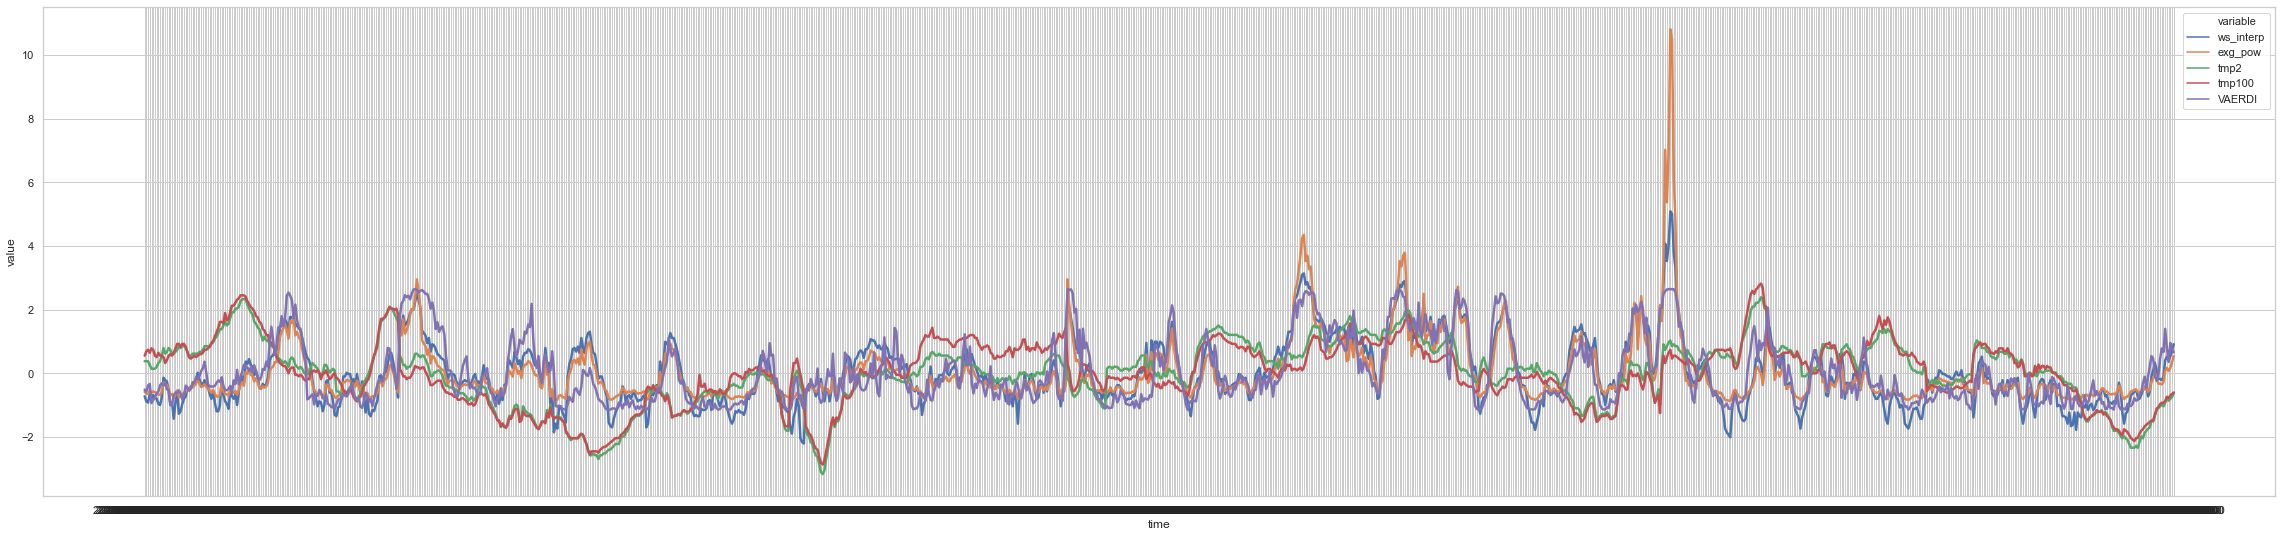

In [267]:
plt.figure(figsize=(40,9))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(train_plt, ['time']), hue='variable',linewidth=2.5)

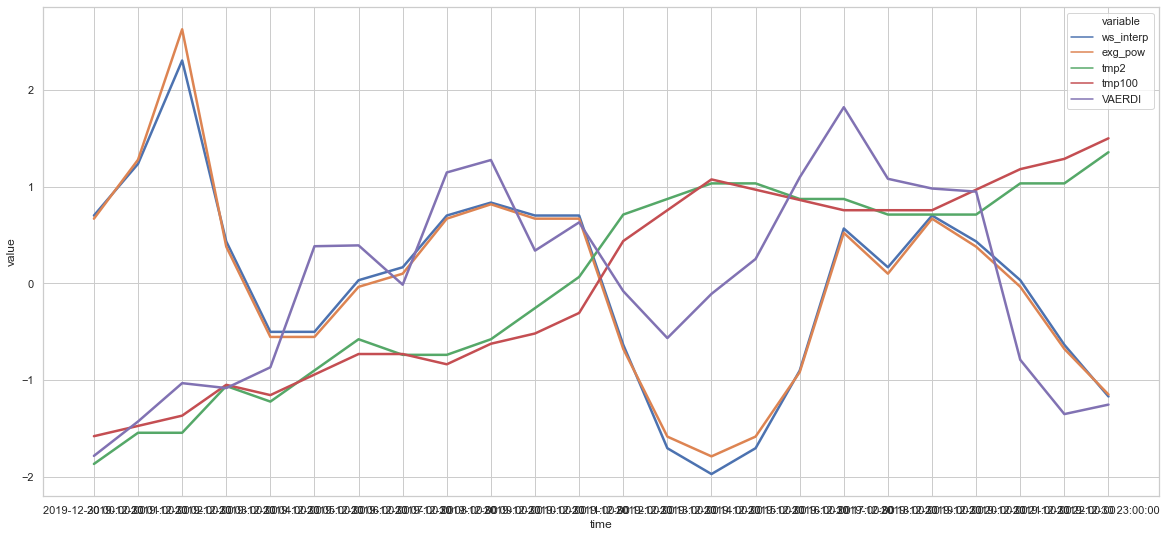

In [109]:
plt.figure(figsize=(20,9))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(test_plt, ['time']), hue='variable',linewidth=2.5)

## LSTM

In [261]:
def train_model(
  model, 
  lr,
  num_epochs,
  X_train, 
  y_train, 
  X_test=None, 
  y_test=None
):
  loss_fn = torch.nn.MSELoss()

  optimiser = torch.optim.Adam(model.parameters(), lr=lr)
  num_epochs = num_epochs

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()
    # model.zero_grad()
    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if X_test is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0 or t == num_epochs-1:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [263]:
feat_cols = ["ws_interp", "tmp2", "tmp100"] 
# feat_cols = ["month", "hour", "Placement","Turbine_type", "Roughness", "Capacity_kw", "Rotor_diameter", "Navhub_height", "ws10", "ws100", "wd10", "wd100", "tmp2", "tmp100"]
x_train = train_pd[feat_cols]
y_train = train_pd[["VAERDI"]]
x_test = test_pd[feat_cols]
y_test = test_pd[["VAERDI"]]
timeline = test_pd[["TIME_CET"]]

In [264]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [265]:
seq_length = 3
x_train = create_sequences_x(x_train, seq_length)
y_train = create_sequences_y(y_train, seq_length)
x_test = create_sequences_x(x_test, seq_length)
y_test = create_sequences_y(y_test, seq_length)

dtype = torch.float
x_train_tensor = torch.tensor(x_train, dtype = dtype)
y_train_tensor = torch.tensor(y_train, dtype = dtype)
x_test_tensor = torch.tensor(x_test, dtype = dtype)
y_test_tensor = torch.tensor(y_test, dtype = dtype)

In [ ]:
len(x_train_tensor)

In [266]:
model = LSTM_Regression(
  n_features=3, 
  n_hidden=100, 
  seq_len=seq_length, 
  n_layers=3
)
model, train_hist, test_hist = train_model(
  model, 
  0.1,
  100,
  x_train_tensor, 
  y_train_tensor, 
  x_test_tensor, 
  y_test_tensor
)

Epoch 0 train loss: 71958.078125 test loss: 175798.53125
Epoch 10 train loss: 52594.1484375 test loss: 138040.46875
Epoch 20 train loss: 38405.70703125 test loss: 106006.1015625
Epoch 30 train loss: 29557.556640625 test loss: 81214.0546875
Epoch 40 train loss: 25026.19921875 test loss: 63719.54296875
Epoch 50 train loss: 23230.9453125 test loss: 52499.0625
Epoch 60 train loss: 22748.1328125 test loss: 46078.3046875
Epoch 70 train loss: 22694.900390625 test loss: 42980.2109375
Epoch 80 train loss: 22706.970703125 test loss: 41948.5703125
Epoch 90 train loss: 22705.837890625 test loss: 42008.77734375
Epoch 99 train loss: 22699.458984375 test loss: 42424.09375


In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend()

In [ ]:
with torch.no_grad():
    preds = []
    for i in range(len(x_test_tensor)):
        model.reset_hidden_state()
        test_seq = x_test_tensor[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        print(test_seq)
        print(pred)
        # test_seq = x_test_tensor[:1]

## NN

In [240]:
class NN(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)
    self.d = nn.Dropout(p=0.5)

  def forward(self, x):
    x = F.sigmoid(self.fc1(x))
    # x = self.d(x)
    # x = self.fc2(x)
    # x = self.d(x)
    x = self.fc3(x)

    return x

In [241]:
def train_model(
  model, 
  lr,
  num_epochs,
  X_train, 
  y_train, 
  X_test=None, 
  y_test=None
):
  loss_fn = torch.nn.MSELoss()

  optimiser = torch.optim.Adam(model.parameters(), lr=lr)
  num_epochs = num_epochs

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    # model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if X_test is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0 or t == num_epochs-1:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [242]:
def move_col_toend(df, name):
    col = df.pop(name)
    df.insert(len(df.columns),col.name, col)

In [243]:
train_pd = train_pd[train_pd["VAERDI"]>50]

In [244]:
# feat_cols = ["VAERDI", "exg_pow","ws_interp", "tmp2", "tmp100"] 
# # feat_cols = ["month", "hour", "Placement","Turbine_type", "Roughness", "Capacity_kw", "Rotor_diameter", "Navhub_height", "ws10", "ws100", "wd10", "wd100", "tmp2", "tmp100"]
# train = train_pd[feat_cols]
# move_col_toend(train, "VAERDI")
# test = test_pd[feat_cols]
# move_col_toend(test, "VAERDI")
# timeline = test_pd["TIME_CET"]

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler().fit(train)
# train = scaler.transform(train)
# test = scaler.transform(test)

In [253]:
dtype = torch.float
cols = ["ws_interp", "tmp2", "tmp100","Roughness", "Capacity_kw", "Rotor_diameter", "Navhub_height"] 
x_train = train_pd[cols] 
y_train = train_pd[["VAERDI"]]
x_test = test_pd[cols] 
y_test = test_pd[["VAERDI"]]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

x_train_tensor = torch.tensor(x_train, dtype = dtype)
y_train_tensor = torch.tensor(y_train.values, dtype = dtype)
x_test_tensor = torch.tensor(x_test, dtype = dtype)
y_test_tensor = torch.tensor(y_test.values, dtype = dtype)

In [254]:
# dtype = torch.float
# x_train = train[:,:-1]
# y_train = train[:,-1]
# x_test = test[:,:-1]
# y_test = test[:,-1]

# x_train_tensor = torch.tensor(x_train, dtype = dtype)
# y_train_tensor = torch.tensor(y_train, dtype = dtype)
# x_test_tensor = torch.tensor(x_test, dtype = dtype)
# y_test_tensor = torch.tensor(y_test, dtype = dtype)

In [255]:
model = NN(
  input_size=7,
  hidden_size=500,
  output_size=1
)
model, train_hist, test_hist = train_model(
  model, 
  0.05,
  200,
  x_train_tensor, 
  y_train_tensor, 
  x_test_tensor, 
  y_test_tensor
)

Epoch 0 train loss: 71806.703125 test loss: 155994.359375
Epoch 10 train loss: 23595.05859375 test loss: 54953.30859375
Epoch 20 train loss: 12518.806640625 test loss: 12499.9560546875
Epoch 30 train loss: 8557.3984375 test loss: 10936.7568359375
Epoch 40 train loss: 7336.16748046875 test loss: 12997.69921875
Epoch 50 train loss: 6880.494140625 test loss: 12234.0078125
Epoch 60 train loss: 6528.4287109375 test loss: 11848.8564453125
Epoch 70 train loss: 6311.2861328125 test loss: 12061.4580078125
Epoch 80 train loss: 6129.59912109375 test loss: 12554.4248046875
Epoch 90 train loss: 5996.9228515625 test loss: 12714.4306640625
Epoch 100 train loss: 5890.884765625 test loss: 12903.74609375
Epoch 110 train loss: 5806.82861328125 test loss: 13210.578125
Epoch 120 train loss: 5739.25439453125 test loss: 13468.60546875
Epoch 130 train loss: 5684.19677734375 test loss: 13688.0517578125
Epoch 140 train loss: 5639.6708984375 test loss: 13941.96484375
Epoch 150 train loss: 5604.16552734375 test l

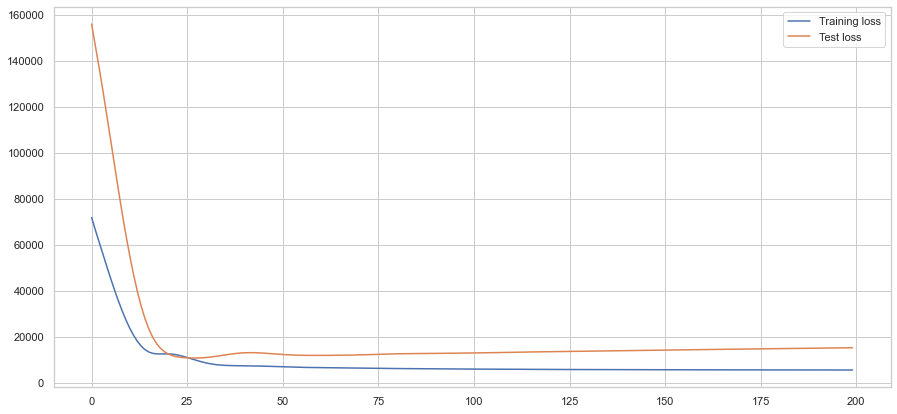

In [256]:
plt.figure(figsize=(15,7))
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend()

In [257]:
y_pred_tensor = model(x_test_tensor)
y_pred = y_pred_tensor.detach().flatten().numpy()


In [258]:
# scaler.min_, scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
# y_test = scaler.inverse_transform([y_test]).flatten()
# y_pred = scaler.inverse_transform([y_pred]).flatten()

In [259]:
# pltdf = pd.DataFrame({"time":timeline, "origin":y_test, "pred":y_pred})
# plt.figure(figsize=(15,6))
# sns.set(style="whitegrid")
# sns.lineplot(x="time",  y="value", data=pd.melt(pltdf, ['time']), hue='variable',linewidth=2.5)

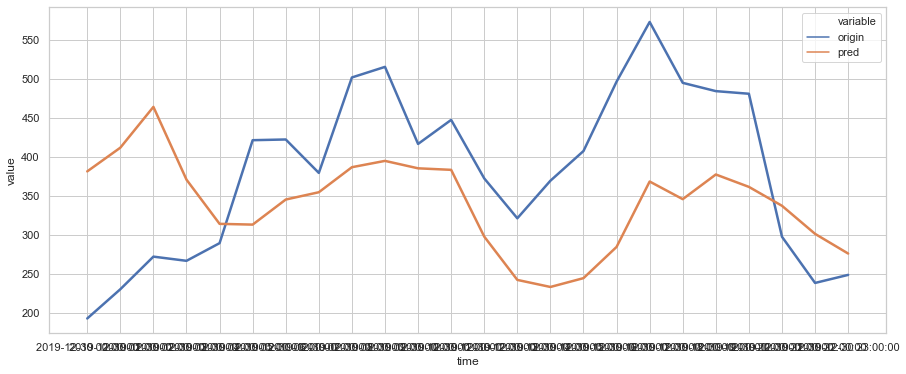

In [260]:
pltdf = pd.DataFrame({"time":timeline, "origin":y_test.values.flatten(), "pred":y_pred})
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(pltdf, ['time']), hue='variable',linewidth=2.5)

# Linear Regression

In [204]:
timeline = test_pd["TIME_CET"]

dtype = torch.float
cols = ["ws_interp", "tmp2", "tmp100","Roughness", "Capacity_kw", "Rotor_diameter", "Navhub_height"] 
x_train = train_pd[cols] 
y_train = train_pd[["VAERDI"]]
x_test = test_pd[cols] 
y_test = test_pd[["VAERDI"]]

In [123]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(x_train)
# x_train = scaler.transform(x_train)
# x_test = scaler.transform(x_test)

In [124]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(x_train, y_train)

In [125]:
y_pred = ereg.predict(x_test)

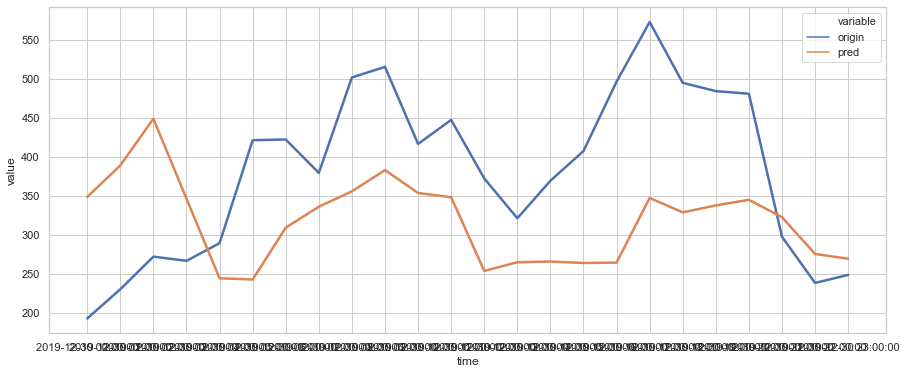

In [126]:
pltdf = pd.DataFrame({"time":timeline, "origin":y_test.values.flatten(), "pred":y_pred})
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(pltdf, ['time']), hue='variable',linewidth=2.5)

# MLR

In [127]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=500).fit(x_train, y_train)
y_pred = regr.predict(x_test)


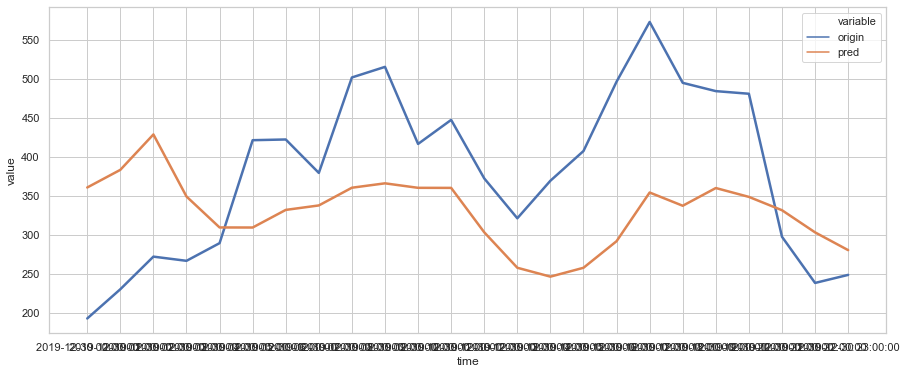

In [128]:
pltdf = pd.DataFrame({"time":timeline, "origin":y_test.values.flatten(), "pred":y_pred})
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(pltdf, ['time']), hue='variable',linewidth=2.5)

In [129]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3)).fit(x_train, y_train)
y_pred = reg.predict(x_test)

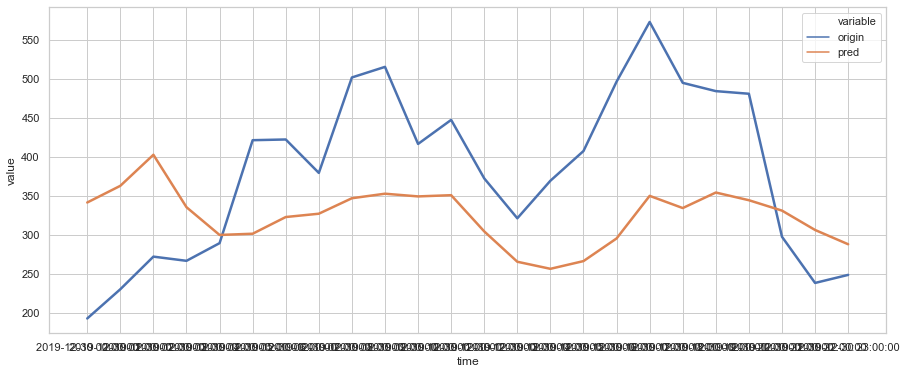

In [130]:
pltdf = pd.DataFrame({"time":timeline, "origin":y_test.values.flatten(), "pred":y_pred})
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(pltdf, ['time']), hue='variable',linewidth=2.5)

# Nearest Neighbor

In [159]:
from sklearn.neighbors import RadiusNeighborsRegressor
neigh = RadiusNeighborsRegressor(radius=9.0, weights = 'uniform')
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_test)

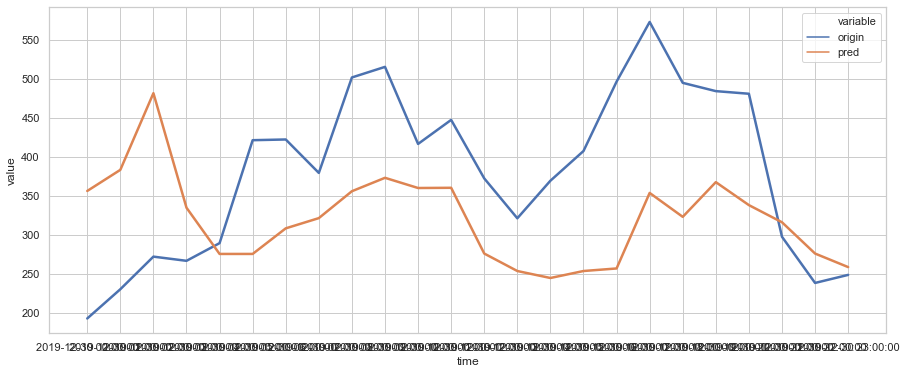

In [160]:
pltdf = pd.DataFrame({"time":timeline, "origin":y_test.values.flatten(), "pred":y_pred.flatten()})
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(pltdf, ['time']), hue='variable',linewidth=2.5)

# Exchange Prediction

In [234]:
exg = train_pd[["TIME_CET", "ws_interp", "VAERDI"]]
exg["exg"] = exg["VAERDI"] / exg["ws_interp"]

In [237]:
exg[["ws_interp", "VAERDI","exg"]] = (exg[["ws_interp", "VAERDI","exg"]]-exg[["ws_interp", "VAERDI","exg"]].mean())/exg[["ws_interp", "VAERDI","exg"]].std()

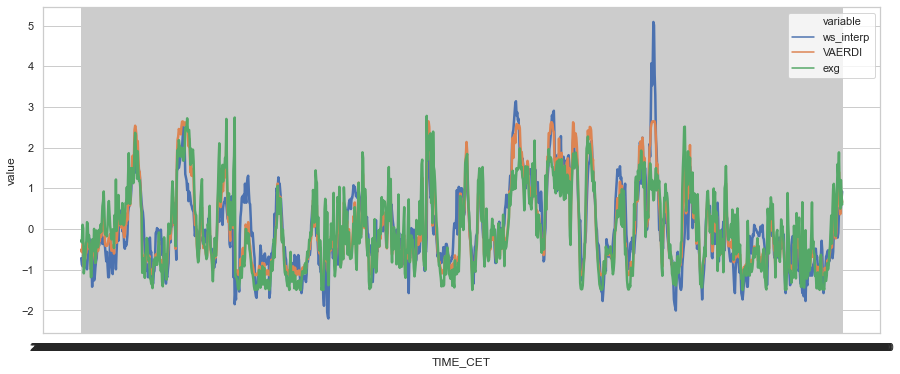

In [238]:
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
sns.lineplot(x="TIME_CET",  y="value", data=pd.melt(exg, ['TIME_CET']), hue='variable', linewidth=2.5)